   # Garbage Classification

Data consists of 2527 garbage images of 6 types: cardboard, glass, metal, paper, plastic and trash.

In order to decrease algorithms' learning time, all the images will be decreased by IMG_DECR_COEF times (default: 16).
But, obviously, it pretty influences the quality of image, and, in accordance, algorithms precision.

An RGB images will be transformed into grayscale arrays.

## Global variables

In [1]:
BASE_PATH = '../Garbage classification/Garbage classification/'

FULL_DATASET  = 'one-indexed-files.txt'
TRAIN_DATASET = 'one-indexed-files-notrash_train.txt'
TEST_DATASET  = 'one-indexed-files-notrash_test.txt'
VAL_DATASET   = 'one-indexed-files-notrash_val.txt'
ZERO_IDX_DATASET = 'zero-indexed-files.txt'

CLASSES = {
        "glass":     1,
        "paper":     2,
        "cardboard": 3,
        "plastic":   4,
        "metal":     5,
        "trash":     6
    }
TARGET_CLASS = "cardboard"

TO_DECREASE_IMG = True
IMG_DECR_COEF = 16
ORIGINAL_SIZE = [0, 0]
DECR_SIZE = [0, 0]

## Logistic Regression methods

In [2]:
def normalize(X):
    mean = np.mean(X)
    std = np.std(X)
    X_new = (X - mean) / (std**2)
    return X_new, mean, std

In [3]:
def prepare_X(X):
    X = pd.DataFrame(X)
    m = X.shape[0]
    ones = np.ones((m, 1))
    X_new = np.column_stack((ones, X))
    X_new = pd.DataFrame(X_new)
    return X_new

In [4]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

In [5]:
def h(X, theta):
    z = np.dot(X, theta)
    return sigmoid(z)

In [6]:
def cost_function(X, y, theta):
    m = X.shape[0]
    if m == 0:
        return None
    _h = h(X, theta)
    J = (1/m) * np.sum(np.dot(-y, np.log(_h)) - np.dot(1-y, np.log(1-_h)))
    return J

In [7]:
def derivative_theta(X, y, theta):
    m = X.shape[0]
    if m == 0:
        return None
    X_t = np.transpose(X)
    hyp = h(X, theta)
    y = np.dot(y, 1)
    d_theta = (1/m) * np.sum( np.dot(X_t, hyp - y) )
    return d_theta

In [8]:
def gradient_descent(X, y, theta, alpha, epsilon, num_iters, print_J = True):
    m = X.shape[0]
    J_history = []
    
    J = cost_function(X, y, theta)
    
    if print_J == True:
        print(J)
    J_history.append(J)
    for i in range(num_iters):
        theta = theta - alpha * derivative_theta(X, y, theta)
        
        J = cost_function(X, y, theta)
        J_history.append(J)
        
        if i % 1000 == 0 and print_J == True:
            print(J)
        
        if abs(J-J_history[-2]) < epsilon:
            break
            
    return theta, J_history

In [9]:
def predict(X, mean, std, theta):
    mean = np.array(mean)
    std = np.array(std)
    mean.reshape((X.shape[0], 1))
    std.reshape((X.shape[0], 1))
    
    X_new = (X - mean) / (std**2)
    X_new = prepare_X(X_new)
    
    predictions = h(X_new, theta)
    return predictions

In [10]:
def MSE(y, y_pred):
    y = np.asarray(y)
    y_pred = np.asarray(y_pred)
    mse = np.mean(np.square(np.subtract(y, y_pred)))
    return mse

In [11]:
def np2pd(np_array_pattern):
    pd_table = pd.DataFrame(data   = np_array_pattern[1:,1:],
                            index  = np_array_pattern[1:,0],
                            columns= np_array_pattern[0,1:])
    return pd_table

## Dataset and image management

In [12]:
def read_dataset(filename):
    df_path = BASE_PATH + filename
    df = pd.read_csv(df_path, sep=' ', names=["picture", "class"])
    X = df["picture"]
    y = df["class"]
    
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    return X, y

### Image-dataset management

In [13]:
def transform_dataset(X):
    # First block is necessary to find out the shape of X and save some image metrics
    # to set here:
    global ORIGINAL_SIZE
    global DECR_SIZE
    global TO_DECREASE_IMG
    
    img_name = X["picture"][0]
    img = Image.open(buildPath(img_name))
    ORIGINAL_SIZE = img.size
    if TO_DECREASE_IMG == True:    
        decr_img = decreaseImg(img)
        DECR_SIZE = decr_img.size
        img_arr = img2gray_vect(decr_img)
    else:
        img_arr = img2gray_vect(img)
    
    X_res = np.zeros((X.shape[0], len(img_arr)))
    
    gray_img_vect = 0
    for i, img_name in enumerate(np.asarray(X["picture"])):
        img = Image.open(buildPath(img_name))
        if TO_DECREASE_IMG == True:
            decr_img = decreaseImg(img)
            gray_img_vect = img2gray_vect(decr_img)
        else:
            gray_img_vect = img2gray_vect(img)
            
        X_res[i][:] = gray_img_vect
        
    X_res = pd.DataFrame(X_res)
    return X_res

In [14]:
def buildPath(img_name):
    global BASE_PATH
    
    #pathes is, in fact, a list, considered to contain a single element
    pathes = glob.glob(os.path.join(BASE_PATH, '*/', img_name))
    path = pathes[0]
    return path

### Garbage classes dataset management

In [15]:
def prepare_target_class(y):
    global TARGET_CLASS
    
    y_res = np.zeros((max(y.shape), 1))
    class_value = get_class_value(TARGET_CLASS)
    for i, _class in enumerate(np.asarray(y)):
        if _class == class_value:
            y_res[i][0] = 1;
    y_res = pd.DataFrame(y_res)
    return y_res

In [16]:
def get_class_value(class_name):
    return CLASSES.get(class_name.lower(), 0)

In [17]:
def int2str_dataset(y):
    for i, (class_str, class_id) in enumerate(CLASSES.items()):
        y = y.replace(class_id, class_str)
    return y

In [18]:
def plot_prop(ax, column, num_bins, x_label, y_label, title):
    n, bins, patches = ax.hist(column, bins=num_bins, density=0)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    
    return patches

### Image management

In [19]:
def img2gray_vect(img):
    img_gray_vect = np.asarray(img.convert('L')).reshape(-1)
    return img_gray_vect

In [20]:
global IMG_DECR_COEF
def decreaseImg(img, decr_coef = IMG_DECR_COEF):
    new_size = np.divide(img.size, decr_coef)
    new_size = [ int(math.modf(new_size[0])[1]), int(math.modf(new_size[1])[1]) ]
    new_img = img.resize(new_size)
    return new_img

In [21]:
def increaseImg(img):
    global IMG_DECR_COEF
    
    new_size = np.dot(img.size, IMG_DECR_COEF)
    new_size = [ int(math.modf(new_size[0])[1]), int(math.modf(new_size[1])[1]) ]
    new_img = img.resize(new_size)
    return new_img

## Imports

In [22]:
import numpy as np
import pandas as pd
from pandas import DataFrame

import PIL
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
import IPython.display

import glob, os
import random

import math

Using TensorFlow backend.


## Data illustration

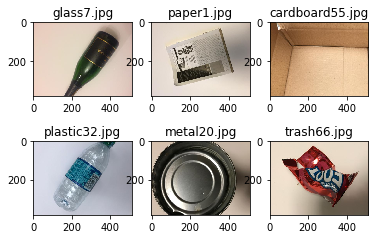

In [23]:
imgs_list = ["glass7.jpg", "paper1.jpg", "cardboard55.jpg", "plastic32.jpg", "metal20.jpg", "trash66.jpg"]
show_gray_img = None

for i, img_name in enumerate(imgs_list):
    img = Image.open(buildPath(img_name))
    img_arr = np.array(img)
    plt.subplot(2, 3, i+1)
    plt.imshow(PIL.Image.fromarray(img_arr))
    plt.title(img_name)
    
    # to show in the next cell:
    show_gray_img = img

Gray representation:


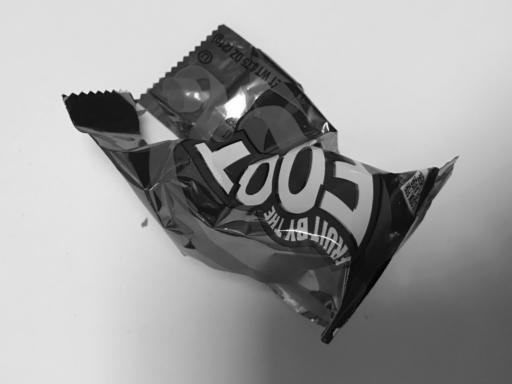

In [24]:
img_gray_vect = np.asarray(show_gray_img.convert('L'))
print("Gray representation:")
IPython.display.display(PIL.Image.fromarray(img_gray_vect))

# Realization

## Prepare datasets

In [25]:
X_train_raw, y_train_raw = read_dataset(TRAIN_DATASET)
X_test_raw, y_test_raw   = read_dataset(TEST_DATASET)
X_val_raw, y_val_raw     = read_dataset(VAL_DATASET)

In [26]:
print("Train datasets' shapes:")
print("X: %s" % np.array(X_train_raw.shape))
print("y: %s" % np.array(y_train_raw.shape))

Train datasets' shapes:
X: [1768    1]
y: [1768    1]


In [27]:
print("Test datasets' shapes:")
print("X: %s" % np.array(X_test_raw.shape))
print("y: %s" % np.array(y_test_raw.shape))

Test datasets' shapes:
X: [431   1]
y: [431   1]


In [28]:
print("Val datasets' shapes:")
print("X: %s" % np.array(X_val_raw.shape))
print("y: %s" % np.array(y_val_raw.shape))

Val datasets' shapes:
X: [328   1]
y: [328   1]


In [29]:
classes = pd.concat([y_train_raw, y_test_raw, y_val_raw])
classes = int2str_dataset(classes)
classes.head(10)

,class
0,cardboard
1,paper
2,paper
3,glass
4,glass
5,metal
6,cardboard
7,trash
8,paper
9,paper


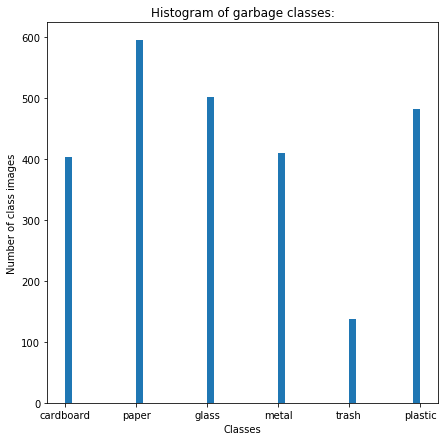

In [30]:
fig, ax = plt.subplots(figsize=(7,7))
ax = plot_prop(ax, classes['class'], 50, 'Classes', 'Number of class images', 'Histogram of garbage classes:')
    
plt.show()

Since data consists of images' names (and images, accordingly), there is no necessity to check for null values.

In [31]:
X_train_raw.head(10)

,picture
0,cardboard202.jpg
1,paper472.jpg
2,paper522.jpg
3,glass189.jpg
4,glass325.jpg
5,metal63.jpg
6,cardboard61.jpg
7,trash50.jpg
8,paper305.jpg
9,paper199.jpg


In [32]:
y_train_raw.head(10)

,class
0,3
1,2
2,2
3,1
4,1
5,5
6,3
7,6
8,2
9,2


You can change whether decrease images or not. If not, it's likely to be a data-overfitting.

Default decision is to decrease by 16 times (IMG_DECR_COEF value)

In [33]:
global IMG_DECR_COEF
global TO_DECREASE_IMG
#IMG_DECR_COEF = 4
iters_count = 500
############################
'''
TO_DECREASE_IMG = False
iters_count = 50
'''
############################
X_train = transform_dataset(X_train_raw)
X_test  = transform_dataset(X_test_raw)
X_val   = transform_dataset(X_val_raw)

You can change which class to classify here or in a cell with global variables above.
Default is cardboard classification.

    1. glass
    2. paper
    3. cardboard
    4. plastic
    5. metal
    6. trash

In [34]:
global TARGET_CLASS
#TARGET_CLASS = "glass"

y_train = prepare_target_class(y_train_raw)
y_test  = prepare_target_class(y_test_raw)
y_val   = prepare_target_class(y_val_raw)

In [35]:
X_train.head(10)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,254.0,...,219.0,219.0,218.0,217.0,215.0,214.0,211.0,208.0,205.0,202.0
1,230.0,230.0,230.0,230.0,232.0,233.0,233.0,236.0,238.0,240.0,...,144.0,105.0,163.0,222.0,229.0,227.0,225.0,223.0,221.0,220.0
2,246.0,246.0,246.0,246.0,241.0,238.0,241.0,241.0,226.0,195.0,...,167.0,166.0,165.0,164.0,163.0,162.0,161.0,160.0,158.0,159.0
3,166.0,165.0,166.0,166.0,165.0,165.0,167.0,168.0,169.0,171.0,...,221.0,220.0,221.0,223.0,225.0,226.0,226.0,225.0,223.0,222.0
4,222.0,221.0,220.0,219.0,218.0,217.0,216.0,216.0,216.0,215.0,...,188.0,185.0,184.0,182.0,179.0,176.0,173.0,169.0,166.0,164.0
5,192.0,191.0,192.0,192.0,192.0,192.0,193.0,194.0,194.0,194.0,...,88.0,38.0,80.0,84.0,84.0,91.0,93.0,70.0,83.0,90.0
6,80.0,75.0,82.0,83.0,77.0,118.0,94.0,106.0,77.0,76.0,...,129.0,137.0,141.0,141.0,228.0,255.0,255.0,255.0,255.0,255.0
7,193.0,194.0,195.0,196.0,197.0,197.0,197.0,198.0,200.0,200.0,...,106.0,102.0,97.0,94.0,93.0,92.0,90.0,88.0,88.0,88.0
8,205.0,202.0,200.0,199.0,198.0,192.0,172.0,165.0,157.0,173.0,...,121.0,156.0,171.0,185.0,173.0,74.0,67.0,72.0,74.0,76.0
9,228.0,226.0,224.0,223.0,223.0,222.0,222.0,222.0,221.0,221.0,...,114.0,112.0,87.0,80.0,101.0,104.0,92.0,79.0,67.0,57.0


In [36]:
y_train.head(10)

,0
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,1.0
7,0.0
8,0.0
9,0.0


In [37]:
X_train_norm, mean_train, std_train = normalize(X_train)
X_test_norm, mean_test, std_test = normalize(X_test)
X_val_norm, mean_val, std_val = normalize(X_val)

In [38]:
X_train_norm.head(10)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.034294,0.035741,0.037236,0.037237,0.037114,0.037192,0.036298,0.036896,0.036052,0.035053,...,0.023930,0.024930,0.025871,0.026545,0.026682,0.026714,0.025909,0.025547,0.025285,0.023833
1,0.017779,0.018863,0.019971,0.020259,0.021769,0.022747,0.022496,0.025067,0.026418,0.027098,...,-0.007979,-0.025062,0.000584,0.028919,0.033516,0.033035,0.032808,0.033161,0.033672,0.033284
2,0.028349,0.029665,0.031021,0.031125,0.027774,0.026030,0.027515,0.028180,0.019192,0.001528,...,0.001806,0.001688,0.001503,0.001377,0.001300,0.001430,0.001271,0.001183,0.000647,0.001255
3,-0.024497,-0.025018,-0.024230,-0.023205,-0.022930,-0.021900,-0.018910,-0.017272,-0.015131,-0.012109,...,0.024781,0.025369,0.027251,0.029394,0.031563,0.032549,0.033301,0.034176,0.034721,0.034334
4,0.012495,0.012787,0.013064,0.012788,0.012429,0.012242,0.011831,0.012614,0.013170,0.012892,...,0.010741,0.010020,0.010239,0.009924,0.009110,0.008237,0.007184,0.005752,0.004840,0.003880
5,-0.007322,-0.007465,-0.006274,-0.005548,-0.004917,-0.004173,-0.002598,-0.001084,-0.000077,0.000960,...,-0.031804,-0.054443,-0.037578,-0.036613,-0.037262,-0.033093,-0.032237,-0.044498,-0.038669,-0.034975
6,-0.081306,-0.085776,-0.082243,-0.079572,-0.081640,-0.052760,-0.064707,-0.055874,-0.070530,-0.066090,...,-0.014361,-0.011029,-0.009532,-0.009545,0.033028,0.046650,0.047591,0.049403,0.051495,0.051662
7,-0.006662,-0.005440,-0.004202,-0.002831,-0.001581,-0.000890,-0.000089,0.001407,0.003536,0.004369,...,-0.024146,-0.026377,-0.029762,-0.031864,-0.032869,-0.032606,-0.033715,-0.035362,-0.036048,-0.036025
8,0.001265,-0.000039,-0.000748,-0.000794,-0.000914,-0.004173,-0.015773,-0.019140,-0.022357,-0.010973,...,-0.017764,-0.002697,0.004262,0.011349,0.006181,-0.041359,-0.045049,-0.043483,-0.043387,-0.042326
9,0.016458,0.016163,0.015827,0.015505,0.015765,0.015525,0.015595,0.016350,0.016181,0.016302,...,-0.020742,-0.021992,-0.034360,-0.038512,-0.028964,-0.026772,-0.032730,-0.039930,-0.047057,-0.052302


## sklearn algorithm

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [40]:
clf = LogisticRegression()
clf.fit(X_train_norm, y_train)

c:\users\nosov\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Training dataset

In [41]:
y_pred_train = clf.predict(X_train_norm)
print(y_pred_train)

[0. 0. 0. ... 0. 0. 0.]


In [42]:
sklearn_acc_train = accuracy_score(y_train, y_pred_train)
sklearn_MSE_train = MSE(y_train, y_pred_train)

print("sklearn algorithm's train dataset accuracy: %f" % sklearn_acc_train)
print("MSE = %f" % sklearn_MSE_train)

sklearn algorithm's train dataset accuracy: 0.852941
MSE = 0.184103


#### Test dataset

In [43]:
y_pred_test = clf.predict(X_test_norm)

In [44]:
sklearn_acc_test = accuracy_score(y_test, y_pred_test)
sklearn_MSE_test = MSE(y_test, y_pred_test)

print("sklearn algorithm's test dataset accuracy: %s" % sklearn_acc_test)
print("MSE = %f" % sklearn_MSE_test)

sklearn algorithm's test dataset accuracy: 0.8445475638051044
MSE = 0.195310


## My algorithm

In [45]:
X_train_norm = prepare_X(X_train_norm)
X_test_norm  = prepare_X(X_test_norm)
X_val_norm   = prepare_X(X_val_norm)

In [46]:
X_train_norm.head(10)

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
0,1.0,0.034294,0.035741,0.037236,0.037237,0.037114,0.037192,0.036298,0.036896,0.036052,...,0.023930,0.024930,0.025871,0.026545,0.026682,0.026714,0.025909,0.025547,0.025285,0.023833
1,1.0,0.017779,0.018863,0.019971,0.020259,0.021769,0.022747,0.022496,0.025067,0.026418,...,-0.007979,-0.025062,0.000584,0.028919,0.033516,0.033035,0.032808,0.033161,0.033672,0.033284
2,1.0,0.028349,0.029665,0.031021,0.031125,0.027774,0.026030,0.027515,0.028180,0.019192,...,0.001806,0.001688,0.001503,0.001377,0.001300,0.001430,0.001271,0.001183,0.000647,0.001255
3,1.0,-0.024497,-0.025018,-0.024230,-0.023205,-0.022930,-0.021900,-0.018910,-0.017272,-0.015131,...,0.024781,0.025369,0.027251,0.029394,0.031563,0.032549,0.033301,0.034176,0.034721,0.034334
4,1.0,0.012495,0.012787,0.013064,0.012788,0.012429,0.012242,0.011831,0.012614,0.013170,...,0.010741,0.010020,0.010239,0.009924,0.009110,0.008237,0.007184,0.005752,0.004840,0.003880
5,1.0,-0.007322,-0.007465,-0.006274,-0.005548,-0.004917,-0.004173,-0.002598,-0.001084,-0.000077,...,-0.031804,-0.054443,-0.037578,-0.036613,-0.037262,-0.033093,-0.032237,-0.044498,-0.038669,-0.034975
6,1.0,-0.081306,-0.085776,-0.082243,-0.079572,-0.081640,-0.052760,-0.064707,-0.055874,-0.070530,...,-0.014361,-0.011029,-0.009532,-0.009545,0.033028,0.046650,0.047591,0.049403,0.051495,0.051662
7,1.0,-0.006662,-0.005440,-0.004202,-0.002831,-0.001581,-0.000890,-0.000089,0.001407,0.003536,...,-0.024146,-0.026377,-0.029762,-0.031864,-0.032869,-0.032606,-0.033715,-0.035362,-0.036048,-0.036025
8,1.0,0.001265,-0.000039,-0.000748,-0.000794,-0.000914,-0.004173,-0.015773,-0.019140,-0.022357,...,-0.017764,-0.002697,0.004262,0.011349,0.006181,-0.041359,-0.045049,-0.043483,-0.043387,-0.042326
9,1.0,0.016458,0.016163,0.015827,0.015505,0.015765,0.015525,0.015595,0.016350,0.016181,...,-0.020742,-0.021992,-0.034360,-0.038512,-0.028964,-0.026772,-0.032730,-0.039930,-0.047057,-0.052302


In [47]:
y_train.head(10)

,0
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,1.0
7,0.0
8,0.0
9,0.0


### Training dataset

In [48]:
theta = np.zeros((X_train_norm.shape[1], 1))
cost_function(X_train_norm, y_train.T, theta)

0.6931471805599454

In [49]:
alpha=0.00005
new_theta, Js = gradient_descent(X_train_norm, y_train.T, theta, alpha, 1e-7, iters_count, False)

In [50]:
cost_function(X_train_norm, y_train.T, new_theta)

0.6709580463247792

In [51]:
y_pred_train = h(X_train_norm, new_theta)

In [52]:
my_acc_train = accuracy_score(y_train, y_pred_train.round())
my_MSE_train = MSE(y_train, y_pred_train)

print("My algorithm's train dataset accuracy: %s" % my_acc_train)
print("MSE = %f" % my_MSE_train)

My algorithm's train dataset accuracy: 0.6940045248868778
MSE = 0.238909


In [53]:
y_pred_train

array([[0.40493957],
       [0.53758289],
       [0.52631894],
       ...,
       [0.51887678],
       [0.59901109],
       [0.46691693]])

### Testing dataset

In [54]:
cost_function(X_test_norm, y_test.T, new_theta)

0.6665323925002659

In [55]:
y_pred_test = h(X_test_norm, new_theta)

In [56]:
my_acc_test = accuracy_score(y_test, y_pred_test.round())
my_MSE_test = MSE(y_test, y_pred_test)

print("My algorithm's test dataset accuracy: %s" % my_acc_test)
print("MSE = %f" % my_MSE_test)

My algorithm's test dataset accuracy: 0.7378190255220418
MSE = 0.236679


## keras algorithm

In [57]:
import tensorflow as tf

from keras.optimizers import SGD
from keras.layers import Dense, Dropout

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras.models import Sequential
from keras.utils import to_categorical

In [58]:
# convert to binary representation
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)

In [59]:
# solution
epochs = 20
learning_rate = 0.1
decay_rate = 0.1
momentum = 0.8

In [60]:
# define the optimizer function
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [61]:
input_dim = X_train_norm.shape[1]
num_classes = 2
batch_size = 196

In [62]:
# build the model
exponential_decay_model = Sequential()
exponential_decay_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim))
exponential_decay_model.add(Dropout(0.1))
exponential_decay_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
exponential_decay_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

In [63]:
# compile the model
exponential_decay_model.compile(loss='categorical_crossentropy', 
                                optimizer=sgd, 
                                metrics=['acc'])

In [64]:
# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [65]:
# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]

Validation datasets are used here for the hyperparameters' tunning. Training data - to fit the model, and it will be tested on Testing dataset.

In [66]:
# fit the model
exponential_decay_model_history = exponential_decay_model.fit(X_train_norm, y_train_binary,
                                                              batch_size=batch_size,
                                                              epochs=epochs,
                                                              callbacks=callbacks_list,
                                                              verbose=1,
                                                              validation_data=(X_val_norm, y_val_binary))

Train on 1768 samples, validate on 328 samples
Epoch 1/20
1768/1768 [==============================] - 1s 324us/step - loss: 0.5741 - acc: 0.7534 - val_loss: 0.4304 - val_acc: 0.8598
Epoch 2/20
1768/1768 [==============================] - 0s 56us/step - loss: 0.4473 - acc: 0.8377 - val_loss: 0.4061 - val_acc: 0.8598
Epoch 3/20
1768/1768 [==============================] - 0s 52us/step - loss: 0.4446 - acc: 0.8377 - val_loss: 0.4055 - val_acc: 0.8598
Epoch 4/20
1768/1768 [==============================] - 0s 52us/step - loss: 0.4444 - acc: 0.8377 - val_loss: 0.4058 - val_acc: 0.8598
Epoch 5/20
1768/1768 [==============================] - 0s 46us/step - loss: 0.4439 - acc: 0.8377 - val_loss: 0.4060 - val_acc: 0.8598
Epoch 6/20
1768/1768 [==============================] - 0s 43us/step - loss: 0.4438 - acc: 0.8377 - val_loss: 0.4060 - val_acc: 0.8598
Epoch 7/20
1768/1768 [==============================] - 0s 46us/step - loss: 0.4439 - acc: 0.8377 - val_loss: 0.4060 - val_acc: 0.8598
Epoch 8

In [67]:
keras_acc_train = exponential_decay_model_history.history['acc'][-1]
print("keras training dataset accuracy: %s" % keras_acc_train)

keras training dataset accuracy: 0.8376697


### Testing dataset

In [68]:
test_pred = exponential_decay_model.predict(X_test_norm)
test_pred = pd.DataFrame(test_pred, columns=["Probability", "Negative probability"])
prob_arr = test_pred["Probability"]
keras_acc_test = np.mean(prob_arr)
print("keras testing dataset accuracy: %s" % keras_acc_test)

keras testing dataset accuracy: 0.8393491


## Conclusion

In [69]:
accuracy_table = np.array([["", "My algorithm", "sklearn", "keras"],
                          ['Train', my_acc_train, sklearn_acc_train, keras_acc_train],
                          ['Test',  my_acc_test,  sklearn_acc_test,  keras_acc_test]])
accuracy_table = np2pd(accuracy_table)


MSE_table = np.array([["", "My algorithm", "sklearn"],
                     ['Train', my_MSE_train, sklearn_MSE_train],
                     ['Test',  my_MSE_test,  sklearn_MSE_test]])
MSE_table = np2pd(MSE_table)

In [70]:
print('Accuracy table for %s classification and image decrease coefficient %d:' % (TARGET_CLASS, IMG_DECR_COEF))
accuracy_table.head()

Accuracy table for cardboard classification and image decrease coefficient 16:


,My algorithm,sklearn,keras
Train,0.6940045248868778,0.8529411764705882,0.8376697
Test,0.7378190255220418,0.8445475638051044,0.8393491


In [71]:
print('MSE table for %s classification and image decrease coefficient %d:' % (TARGET_CLASS, IMG_DECR_COEF))
MSE_table.head()

MSE table for cardboard classification and image decrease coefficient 16:


,My algorithm,sklearn
Train,0.23890894162382248,0.18410313568518252
Test,0.23667932616063952,0.19531010276645797


So, the results of my algorithm are much worse than build-in ones'. To my mind, there are some reasons of it:
1. It is difficult to recognize some clear, unique image features, referring to the definite class: there are really some similar images of DIFFERENT classes
2. It's hard to detect some DISTINCT dependencies between features (grayscale array items) and target (garbage class)
3. Huge amount of data, which is calculated many times. This influences the precision of calculating results
4. The decision to reduce the execution time: the number of iterations is small. Also, I don't use the regularization parameter and don't tune the learning rate in my algorithm
5. As it was mentioned, all the images are reduced in size, and this is one of the reasons of 1. and 2. problems